#### Plot components excluding Bering Strait outflow

In [12]:
import jCMIP as jc
Clist = jc.readList(('CMIP6listnew'))

from netCDF4 import Dataset
from netCDF4 import num2date
import numpy as np
from scipy.integrate import quad
from scipy import stats as st
import matplotlib.pyplot as plt
import cftime
import gsw
from datetime import date, timedelta
import pandas as pd
from scipy.interpolate import interp1d
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import tarfile

#### Historical and RAPID

##### Timeseries

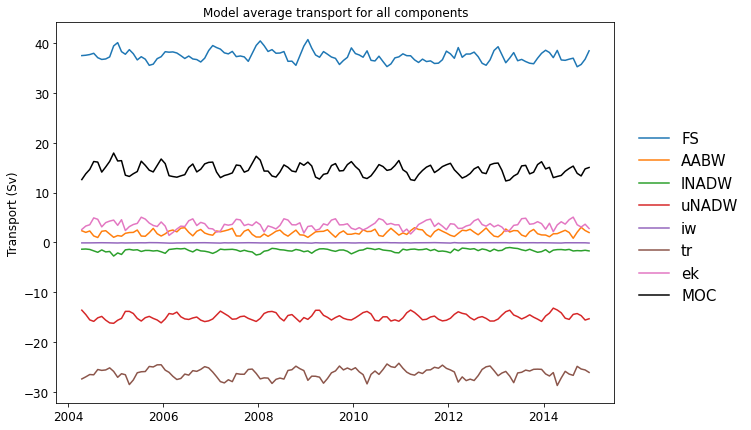

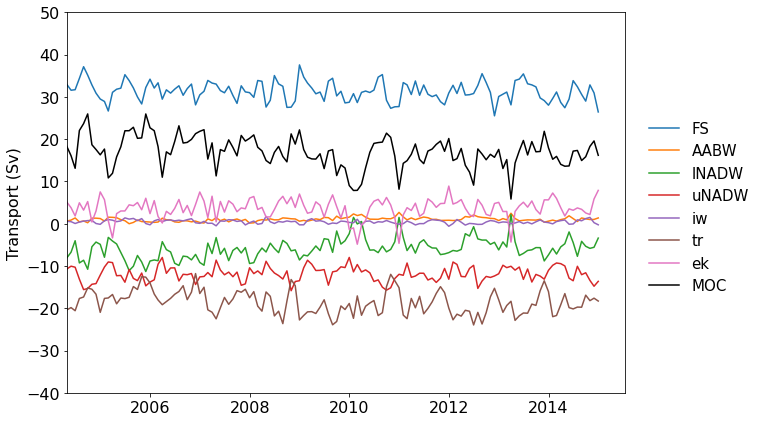

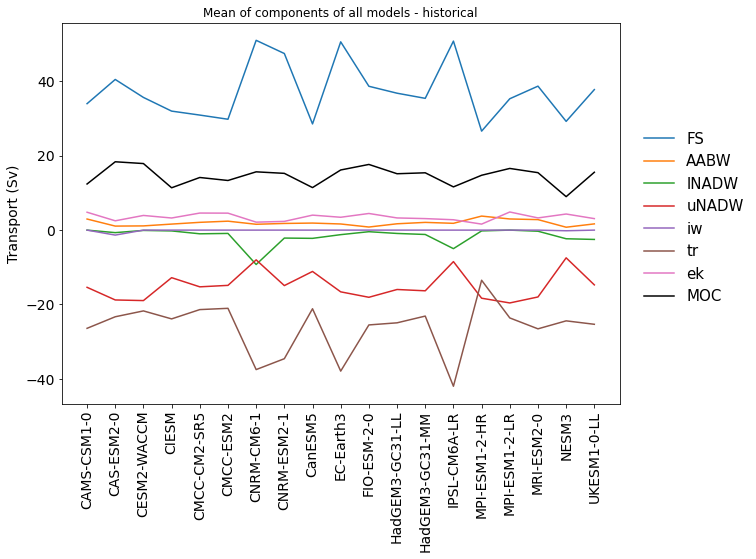

In [48]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'historical'

t10 = 129
fs10tot    = np.zeros((t10,len(totmod)))
AABW10tot  = np.zeros((t10,len(totmod)))
lNADW10tot = np.zeros((t10,len(totmod)))
uNADW10tot = np.zeros((t10,len(totmod)))
iw10tot    = np.zeros((t10,len(totmod)))
tr10tot    = np.zeros((t10,len(totmod)))
ek10tot    = np.zeros((t10,len(totmod)))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/components_tpBS/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    fs10    = ncid.variables['fs10'][:]        
    AABW10  = ncid.variables['AABW10'][:]      
    lNADW10 = ncid.variables['lNADW10'][:]     
    uNADW10 = ncid.variables['uNADW10'][:]     
    iw10    = ncid.variables['iw10'][:]      
    tr10    = ncid.variables['tr10'][:]    
    ek10    = ncid.variables['ek10'][:]      
    ncid.close()
    
    fs10tot[:,i]    = fs10
    AABW10tot[:,i]  = AABW10
    lNADW10tot[:,i] = lNADW10
    uNADW10tot[:,i] = uNADW10
    iw10tot[:,i]    = iw10
    tr10tot[:,i]    = tr10
    ek10tot[:,i]    = ek10

#Calculate ensemble mean transport of all components
fsmean = np.nanmean(fs10tot,axis=1)
AABWmean = np.nanmean(AABW10tot,axis=1)
lNADWmean = np.nanmean(lNADW10tot,axis=1)
uNADWmean = np.nanmean(uNADW10tot,axis=1)
iwmean = np.nanmean(iw10tot,axis=1)
trmean = np.nanmean(tr10tot,axis=1)
ekmean = np.nanmean(ek10tot,axis=1)
mocmean = fsmean + iwmean + trmean + ekmean

#Calculate time mean of all models
fstmean = np.nanmean(fs10tot,axis=0)
AABWtmean = np.nanmean(AABW10tot,axis=0)
lNADWtmean = np.nanmean(lNADW10tot,axis=0)
uNADWtmean = np.nanmean(uNADW10tot,axis=0)
iwtmean = np.nanmean(iw10tot,axis=0)
trtmean = np.nanmean(tr10tot,axis=0)
ektmean = np.nanmean(ek10tot,axis=0)
moctmean = fstmean + iwtmean + trtmean + ektmean

#Change time to date
outfile = ('/home/users/jordi/section26data/' + totmod[6] + '_' + EXP + '_' + ENS[6] + '.nc')  #CNRM-CM6-1 has gregorian calendar, which is supported by python datetime objects
ncid    = Dataset(outfile,'r')
time    = ncid.variables['time'][-129::]
units   = ncid.variables['time'].units
cal     = ncid.variables['time'].calendar
ncid.close()

tdate   = cftime.num2pydate(time,units)

mod_data = np.transpose([tdate,fsmean,ekmean,trmean,iwmean,uNADWmean,lNADWmean,AABWmean,(uNADWmean+lNADWmean),mocmean])
modmean_df = pd.DataFrame(data=mod_data,columns=['date','FS','ekm','tr','iw','uNADW','lNADW','AABW','NADW','MOC'])
modmean_df = modmean_df.set_index('date')

plt.figure(1,figsize=(10,7))
plt.title('Model average transport for all components')
plt.plot(tdate,fsmean,label='FS')
plt.plot(tdate,AABWmean,label='AABW')
plt.plot(tdate,lNADWmean,label='lNADW')
plt.plot(tdate,uNADWmean,label='uNADW')
plt.plot(tdate,iwmean,label='iw')
plt.plot(tdate,trmean,label='tr')
plt.plot(tdate,ekmean,label='ek')
plt.plot(tdate,mocmean,label='MOC',color='k')
plt.ylabel('Transport (Sv)',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 15},frameon=False)

#Plot RAPID data
outfile = ('/home/users/jordi/RAPID_data/moc_transports.nc')
ncid = Dataset(outfile,'r')
time = len(ncid.variables['t_umo10'][:])
umo  = ncid.variables['t_umo10'][28:7822]
gs  = ncid.variables['t_gs10'][28:7822]
ekm  = ncid.variables['t_ek10'][28:7822]
moc   = ncid.variables['moc_mar_hc10'][28:7822]
tr   = ncid.variables['t_therm10'][28:7822]
iw   = ncid.variables['t_aiw10'][28:7822]
uNADW   = ncid.variables['t_ud10'][28:7822]
lNADW   = ncid.variables['t_ld10'][28:7822]
AABW   = ncid.variables['t_bw10'][28:7822]
ncid.close()

#Change time to date
trapid = np.arange(0,time/2,0.5)                #12-hourly data
drapid1   = cftime.num2pydate(trapid,units='days since 2004-04-02 00:00:00')
drapid = drapid1[28:7822]                            #drapid1[28] = 2004-04-16 00:00:00 and drapid1[7822] = 2014-12-16 12:00:00

#Monthly average RAPID data
rapid_data = np.transpose([drapid,gs,ekm,tr,iw,uNADW,lNADW,AABW,(uNADW+lNADW),moc])
rapid_df = pd.DataFrame(data=rapid_data,columns=['date','gs','ekm','tr','iw','uNADW','lNADW','AABW','NADW','MOC'])
rapid_df_index = rapid_df.set_index('date')
rapid_monthly = rapid_df_index.resample('M').mean()

plt.figure(2,figsize=(10,7))
#plt.title('RAPID')
plt.plot(rapid_monthly.index.values,rapid_monthly['gs'],label='FS')
plt.plot(rapid_monthly.index.values,rapid_monthly['AABW'],label='AABW')
plt.plot(rapid_monthly.index.values,rapid_monthly['lNADW'],label='lNADW')
plt.plot(rapid_monthly.index.values,rapid_monthly['uNADW'],label='uNADW')
plt.plot(rapid_monthly.index.values,rapid_monthly['iw'],label='iw')
plt.plot(rapid_monthly.index.values,rapid_monthly['tr'],label='tr')
plt.plot(rapid_monthly.index.values,rapid_monthly['ekm'],label='ek')
plt.plot(rapid_monthly.index.values,rapid_monthly['MOC'],label='MOC',color='k')
plt.gca().set_ylim([-40,50])
plt.ylabel('Transport (Sv)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 15},frameon=False)
plt.xlim(left=rapid_monthly.index.values[0])

plt.figure(3,figsize=(10,7))
plt.title('Mean of components of all models - historical')
plt.xticks(rotation=90)
plt.plot(totmod,fstmean,label='FS')
plt.plot(totmod,AABWtmean,label='AABW')
plt.plot(totmod,lNADWtmean,label='lNADW')
plt.plot(totmod,uNADWtmean,label='uNADW')
plt.plot(totmod,iwtmean,label='iw')
plt.plot(totmod,trtmean,label='tr')
plt.plot(totmod,ektmean,label='ek')
plt.plot(totmod,moctmean,label='MOC',color='k')
plt.ylabel('Transport (Sv)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 15},frameon=False)

##### Write time series to file for lagged regression

In [6]:
mod_hist = np.transpose([tdate,fsmean,trmean,(uNADWmean+lNADWmean),mocmean])
mod_df = pd.DataFrame(data=mod_hist,columns=['date','FS','tr','NADW','MOC'])
mod_df_index = mod_df.set_index('date')
mod_annual = mod_df_index.resample('A').mean()

outfile = ('/home/users/jordi/historical_ts.nc')
ncid = Dataset(outfile,'w')
ncid.createDimension('time', len(mod_annual.index.values)) 
ncid.createVariable('time',    'f8', ('time',))
ncid.createVariable('FS',    'f8', ('time',))
ncid.createVariable('tr',    'f8', ('time',))
ncid.createVariable('NADW',    'f8', ('time',))
ncid.createVariable('MOC',    'f8', ('time',))

ncid.variables['time'][:]    = mod_annual.index.values
ncid.variables['FS'][:]      = mod_annual['FS'].values
ncid.variables['tr'][:]      = mod_annual['tr'].values
ncid.variables['NADW'][:]    = mod_annual['NADW'].values
ncid.variables['MOC'][:]     = mod_annual['MOC'].values

ncid.close()

##### Compare historical mean with standard deviation

fs
[2.30420187]
2.373424536068883
ek
[2.33819863]
2.102905619033484
tr
[2.75413828]
2.1390793700691266
iw
[0.44073038]
0.03303916570870374
uNADW
[1.75663934]
1.3201557468331448
lNADW
[2.45323617]
0.8657191381289997
AABW
[0.47787579]
1.4220427855472122
NADW
[3.29477612]
1.8124249572473765
MOC
[3.65235694]
2.548476604709352


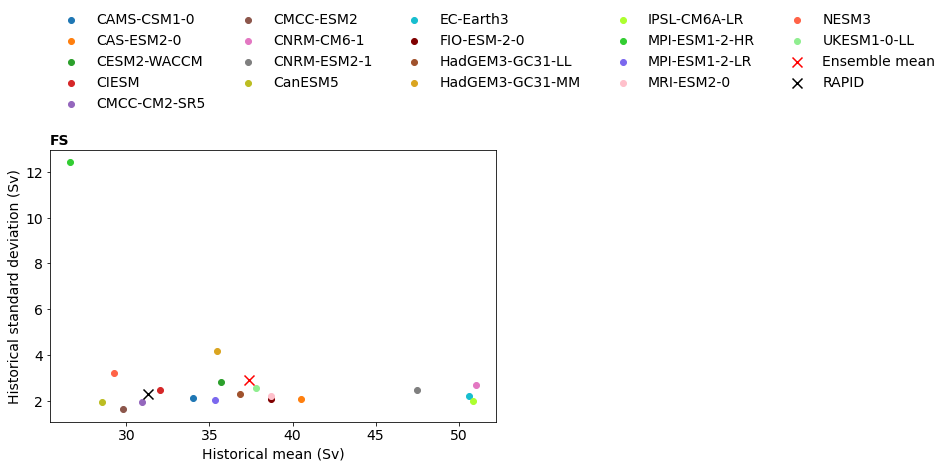

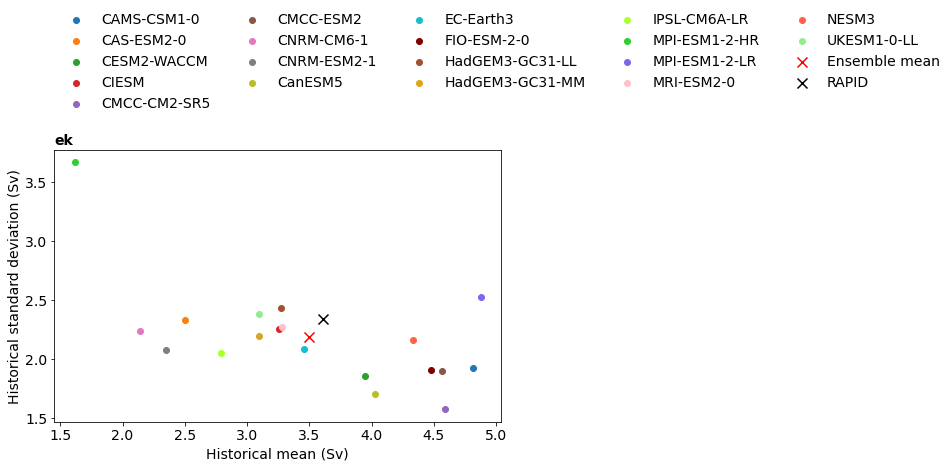

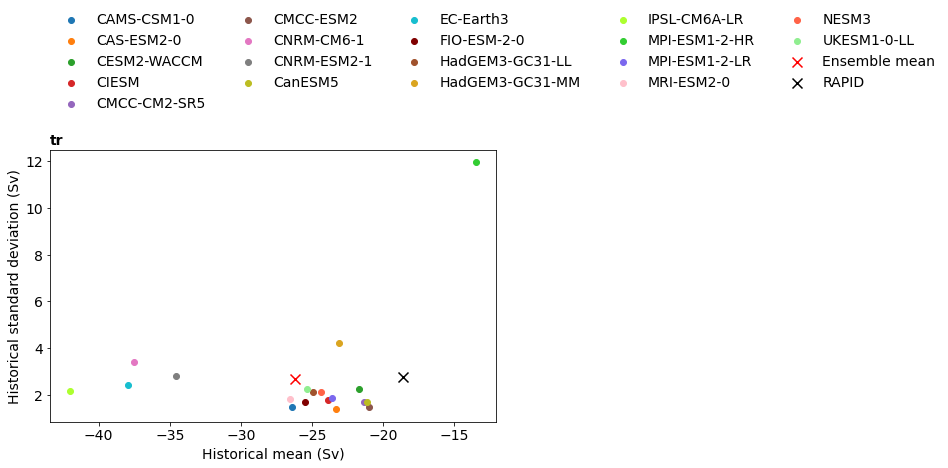

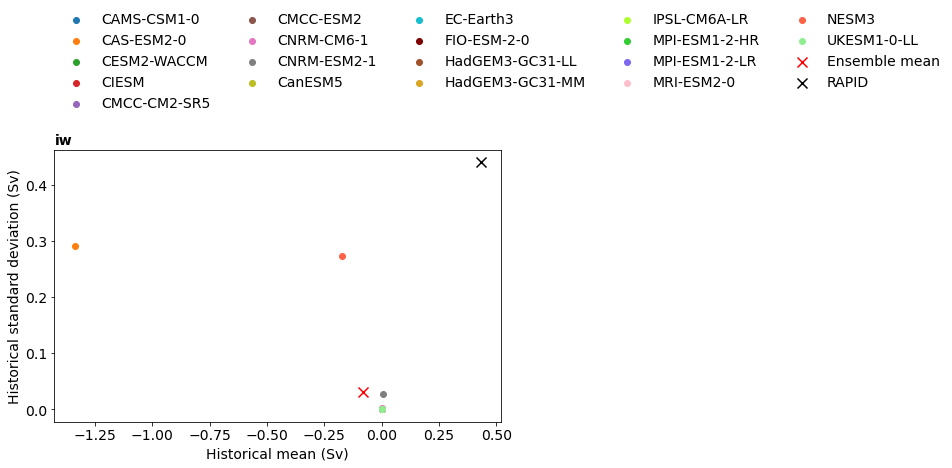

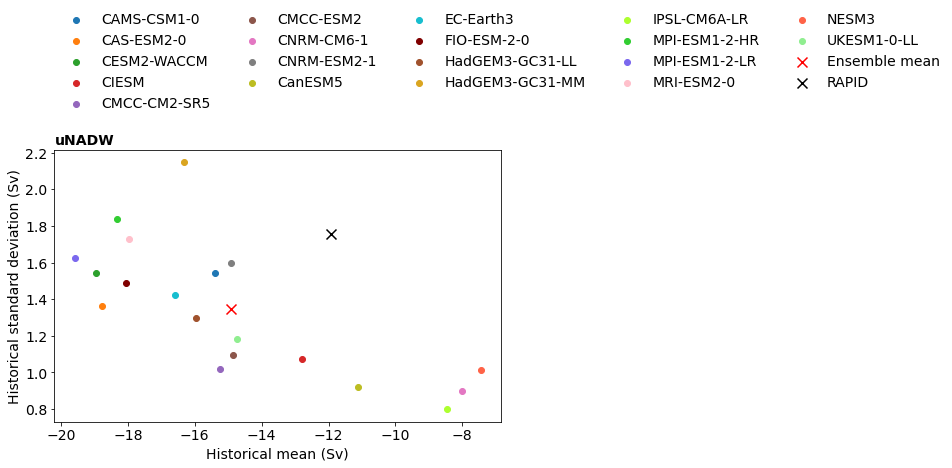

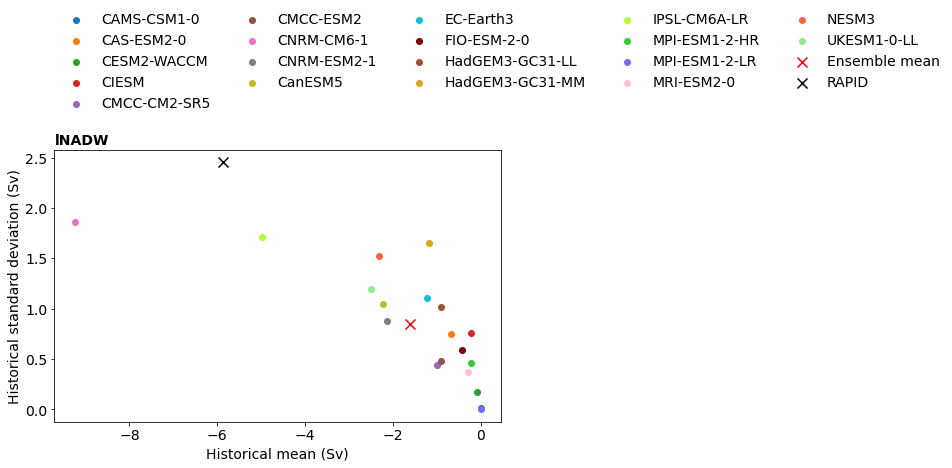

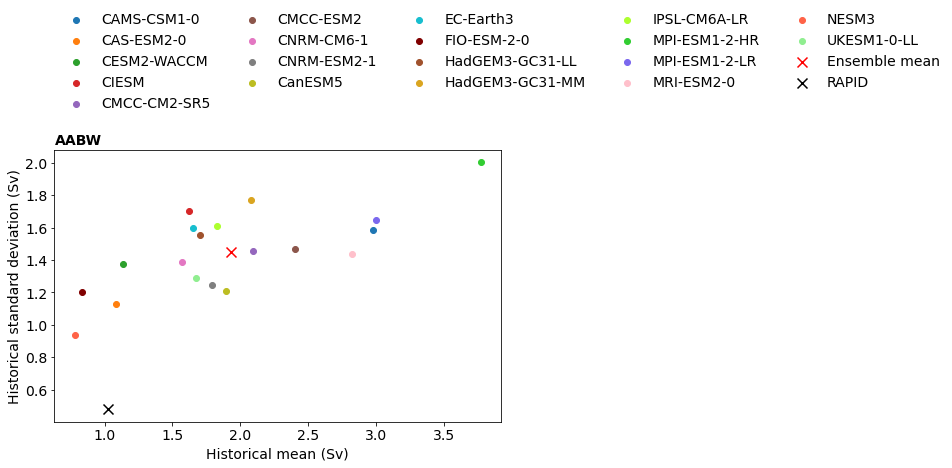

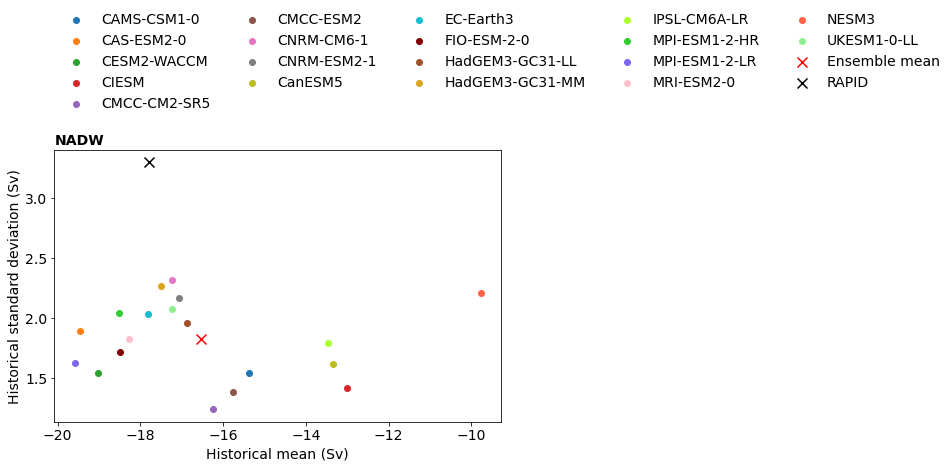

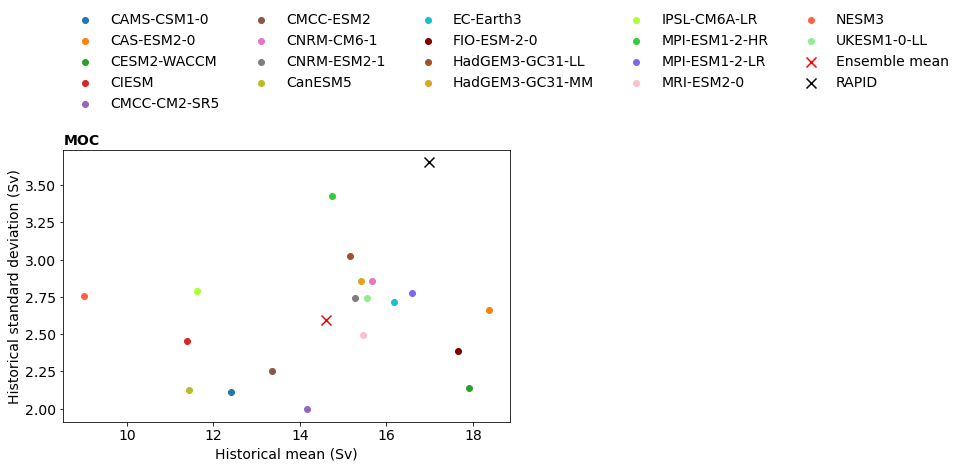

In [9]:
totmod     =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
               'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
comp       = ['fs','ek','tr','iw','uNADW','lNADW','AABW','NADW','MOC']
comp_rapid = ['gs','ekm','tr','iw','uNADW','lNADW','AABW','NADW','MOC']
comp_title = ['FS','ek','tr','iw','uNADW','lNADW','AABW','NADW','MOC']

NADW10tot = uNADW10tot + lNADW10tot
fstmean = np.nanmean(fs10tot,axis=0)
AABWtmean = np.nanmean(AABW10tot,axis=0)
lNADWtmean = np.nanmean(lNADW10tot,axis=0)
uNADWtmean = np.nanmean(uNADW10tot,axis=0)
iwtmean = np.nanmean(iw10tot,axis=0)
trtmean = np.nanmean(tr10tot,axis=0)
ektmean = np.nanmean(ek10tot,axis=0)
NADWtmean = np.nanmean(NADW10tot,axis=0)

data = [fs10tot,ek10tot,tr10tot,iw10tot,uNADW10tot,lNADW10tot,AABW10tot,NADW10tot,(fs10tot+ek10tot+tr10tot+iw10tot)]
data_mean = np.nanmean(data,axis=1)
data_meandf = pd.DataFrame(data=np.transpose(data_mean),columns=comp)
#data_meandf.to_pickle('/home/users/jordi/histmean_mod.pkl')

#Compute standard deviation of timeseries
std  = np.zeros((len(data),len(totmod)))
std_rapid = np.zeros((1,len(comp_rapid)))
for i in range(len(data)):
    std[i] = np.std(data[i],axis=0)
    std_rapid[0,i] = np.std(rapid_monthly[comp_rapid[i]])

std_df = pd.DataFrame(data=np.transpose(std),columns=comp)
std_rapiddf = pd.DataFrame(data=(std_rapid),columns=comp)

for i in range(len(comp)):
    plt.figure(i,figsize=(8,5))
    plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen'])
    for j in range(len(totmod)):
        plt.scatter(data_meandf[comp[i]][j],std_df[comp[i]][j],label=str(totmod[j]))
    plt.scatter(data_meandf[comp[i]].mean(),std_df[comp[i]].mean(),label='Ensemble mean',marker='x',c='r',s=100)
    plt.scatter(rapid_df[comp_rapid[i]].mean(),std_rapiddf[comp[i]],label='RAPID',marker='x',c='k',s=100)
    plt.title(str(comp_title[i]),fontsize=14,fontweight='bold',loc='left')
    plt.xlabel('Historical mean (Sv)',fontsize=14)
    plt.ylabel('Historical standard deviation (Sv)',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(prop={'size': 14},frameon=False)
    #plt.legend(loc='center left',bbox_to_anchor=(1.02, 0.5),prop={'size': 10},frameon=False)
    plt.legend(loc='lower center',bbox_to_anchor=(1, 1.1),ncol = 5,prop={'size': 14},frameon=False)

##### Plot decomposition of RAPID  and model data

       Low freq  Seasonal  High freq
FS     0.653638  1.034185   2.041023
ek     0.786821  0.973162   1.979731
tr     1.300904  1.559987   1.813836
iw     0.156693  0.222078   0.352145
uNADW  0.460463  1.090667   1.323440
lNADW  1.359130  0.690052   1.872268
NADW   1.487960  1.602462   2.341050
AABW   0.272329  0.126848   0.368949
MOC    1.711277  1.665891   2.632873


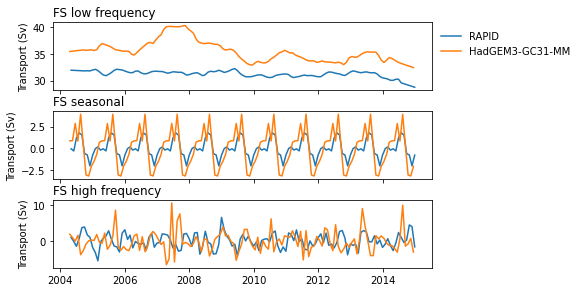

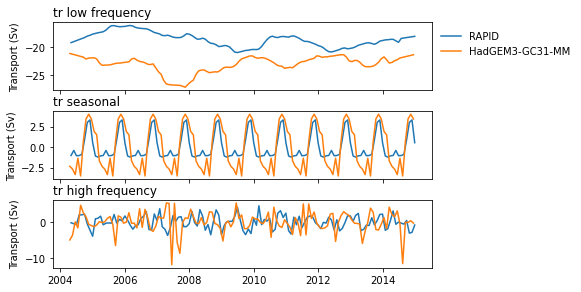

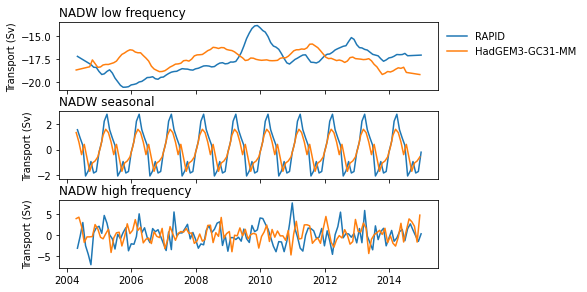

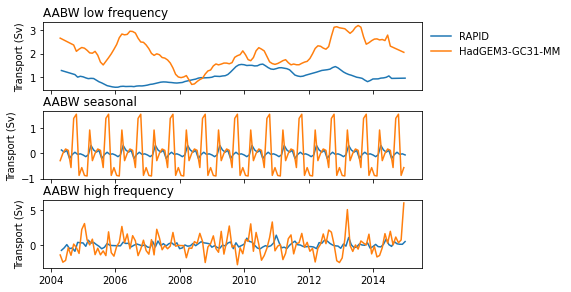

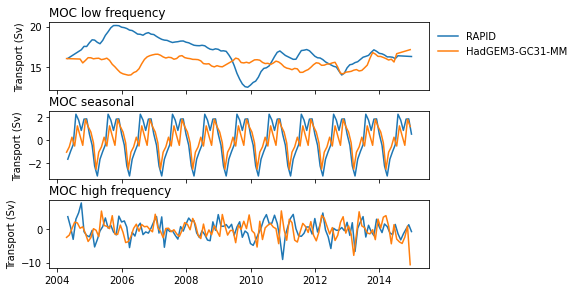

In [3]:
comp_rapid = ['gs','ekm','tr','iw','uNADW','lNADW','NADW','AABW','MOC']
comp_rapid_edit = ['FS','ek','tr','iw','uNADW','lNADW','NADW','AABW','MOC']

totmod   = ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
mod      = 12
comp_mod = [fs10tot[:,mod],ek10tot[:,mod],tr10tot[:,mod],iw10tot[:,mod],uNADW10tot[:,mod],lNADW10tot[:,mod],(uNADW10tot+lNADW10tot)[:,mod],AABW10tot[:,mod],(fs10tot+ek10tot+tr10tot+iw10tot)[:,mod]]

rlowf_df   = pd.DataFrame(data=[],columns=comp_rapid_edit)
rseas_df   = pd.DataFrame(data=[],columns=comp_rapid_edit)
rhighf_df  = pd.DataFrame(data=[],columns=comp_rapid_edit)

tstd = np.zeros(len(comp_rapid))
sstd = np.zeros(len(comp_rapid))
rstd = np.zeros(len(comp_rapid))
sstdmod = np.zeros(len(comp_mod))
for i in range (len(comp_rapid)):
    sd = seasonal_decompose(rapid_monthly[comp_rapid[i]],model='additive',period=12,extrapolate_trend='freq')   #Decomposition with period of 12 months, trend is extrapolated
    sdmod = seasonal_decompose(comp_mod[i],model='additive',period=12,extrapolate_trend='freq')
    tstd[i]   = np.std(sd.trend)
    sstd[i]   = np.std(sd.seasonal)
    sstdmod[i]   = np.std(sdmod.seasonal)
    rstd[i]   = np.std(sd.resid)
    rlowf_df[comp_rapid_edit[i]] = sd.trend
    rseas_df[comp_rapid_edit[i]] = sd.seasonal
    rhighf_df[comp_rapid_edit[i]] = sd.resid
    if i in [0,2,6,7,8]:
        fig,ax = plt.subplots(3,sharex=True)
        fig.tight_layout()
        ax[0].plot(sd.trend,label='RAPID')
        ax[0].plot(tdate,sdmod.trend,label=str(totmod[mod]))
        ax[0].set_title(str(comp_rapid_edit[i]) + ' low frequency',loc='left')
        ax[0].set_ylabel('Transport (Sv)')
        ax[1].plot(sd.seasonal)
        ax[1].plot(tdate,sdmod.seasonal)
        ax[1].set_title(str(comp_rapid_edit[i]) + ' seasonal',loc='left')
        ax[1].set_ylabel('Transport (Sv)')
        ax[2].plot(sd.resid)
        ax[2].plot(tdate,sdmod.resid)
        ax[2].set_title(str(comp_rapid_edit[i]) + ' high frequency',loc='left')
        ax[2].set_ylabel('Transport (Sv)')
        ax[0].legend(bbox_to_anchor=(1, 1),frameon=False)
    
rapid_std   = pd.DataFrame(data=np.transpose([tstd,sstd,rstd]),columns=['Low freq','Seasonal','High freq'],index=comp_rapid_edit)
print(rapid_std)

##### Historical CMIP standard deviation and decomposition

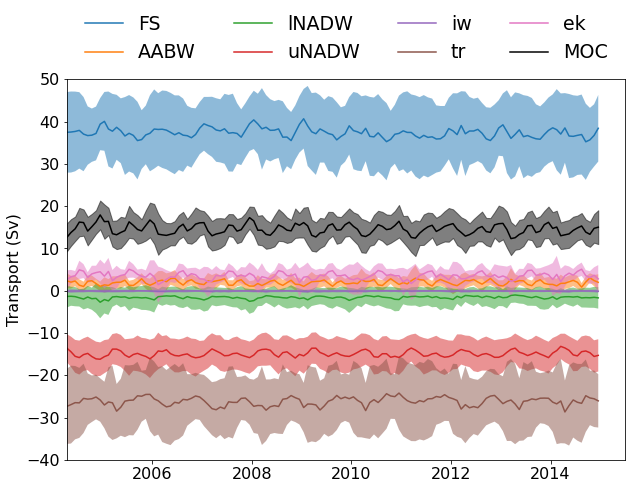

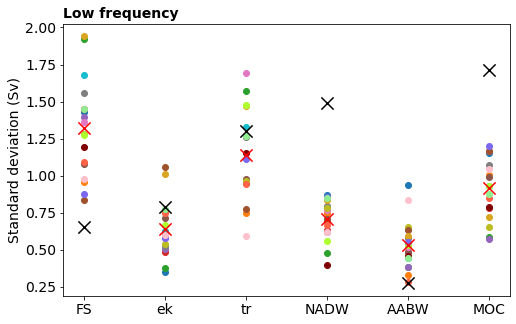

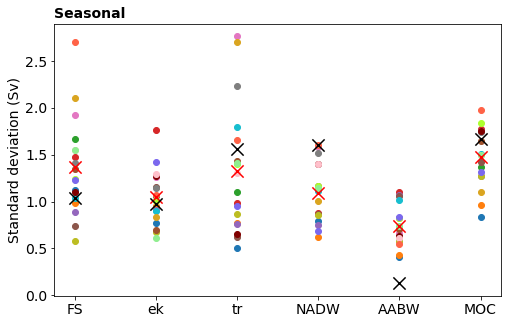

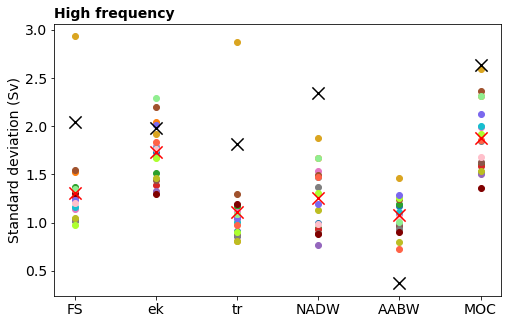

In [4]:
totmod   = ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
data     = [fs10tot,ek10tot,tr10tot,iw10tot,uNADW10tot,lNADW10tot,(uNADW10tot+lNADW10tot),AABW10tot,(fs10tot+ek10tot+tr10tot+iw10tot)]
comp_col = ['FS','ek','tr','iw','uNADW','lNADW','NADW','AABW','MOC']

multi_col = pd.MultiIndex.from_product([totmod,comp_col])
lowf_df   = pd.DataFrame(data=[],columns=multi_col)
seas_df   = pd.DataFrame(data=[],columns=multi_col)
highf_df  = pd.DataFrame(data=[],columns=multi_col)

std        = np.zeros((len(data),len(tdate)))
trange_mod = np.zeros((len(data),len(totmod)))
srange_mod = np.zeros((len(data),len(totmod)))
tstd_mod   = np.zeros((len(data),len(totmod)))
sstd_mod   = np.zeros((len(data),len(totmod)))
rstd_mod   = np.zeros((len(data),len(totmod)))
for i in range(len(data)):
    std[i] = np.std(data[i],axis=1)
    for j in range (len(totmod)):
        sd_mod = seasonal_decompose(data[i][:,j],model='additive',period=12,extrapolate_trend='freq')   #Decomposition with period of 12 months, trend is extrapolated
        trange_mod[i,j] = max(sd_mod.trend) - min(sd_mod.trend)
        srange_mod[i,j] = max(sd_mod.seasonal) - min(sd_mod.seasonal)
        tstd_mod[i,j]   = np.nanstd(sd_mod.trend)
        sstd_mod[i,j]   = np.nanstd(sd_mod.seasonal)
        rstd_mod[i,j]   = np.nanstd(sd_mod.resid)
        lowf_df[totmod[j],comp_col[i]] = sd_mod.trend
        seas_df[totmod[j],comp_col[i]] = sd_mod.seasonal
        highf_df[totmod[j],comp_col[i]] = sd_mod.resid

std_df = pd.DataFrame(data=np.transpose(std),columns=comp_col)
trange_mod_df = pd.DataFrame(data=np.transpose(trange_mod),columns=comp_col,index=totmod)
srange_mod_df = pd.DataFrame(data=np.transpose(srange_mod),columns=comp_col,index=totmod)
tstd_mod_df = pd.DataFrame(data=np.transpose(tstd_mod),columns=comp_col,index=totmod)
sstd_mod_df = pd.DataFrame(data=np.transpose(sstd_mod),columns=comp_col,index=totmod)
rstd_mod_df = pd.DataFrame(data=np.transpose(rstd_mod),columns=comp_col,index=totmod)

srange_mean = np.zeros(len(comp_col))
trange_mean = np.zeros(len(comp_col))
tstd_mean   = np.zeros(len(comp_col))
sstd_mean   = np.zeros(len(comp_col))
rstd_mean   = np.zeros(len(comp_col))
for i in range (len(comp_col)):
    srange_mean[i] = np.nanmean(srange_mod_df[comp_col[i]])
    trange_mean[i] = np.nanmean(trange_mod_df[comp_col[i]])
    tstd_mean[i]   = np.nanmean(tstd_mod_df[comp_col[i]])
    sstd_mean[i]   = np.nanmean(sstd_mod_df[comp_col[i]])
    rstd_mean[i]   = np.nanmean(rstd_mod_df[comp_col[i]])
    
modrange_mean = pd.DataFrame(data=srange_mean,columns=['seasonal'],index=comp_col)
modrange_mean['interannual'] = trange_mean

modstd_mean = pd.DataFrame(data=tstd_mean,columns=['low freq'],index=comp_col)
modstd_mean['seasonal'] = sstd_mean
modstd_mean['high freq'] = rstd_mean

#Standard deviation
plt.figure(1,figsize=(10,7))
#plt.title('Model average transport for all components')
plt.plot(tdate,fsmean,label='FS')
plt.fill_between(tdate,fsmean-std_df['FS'],fsmean+std_df['FS'],alpha=0.5)
plt.plot(tdate,AABWmean,label='AABW')
plt.fill_between(tdate,AABWmean-std_df['AABW'],AABWmean+std_df['AABW'],alpha=0.5)
plt.plot(tdate,lNADWmean,label='lNADW')
plt.fill_between(tdate,lNADWmean-std_df['lNADW'],lNADWmean+std_df['lNADW'],alpha=0.5)
plt.plot(tdate,uNADWmean,label='uNADW')
plt.fill_between(tdate,uNADWmean-std_df['uNADW'],uNADWmean+std_df['uNADW'],alpha=0.5)
plt.plot(tdate,iwmean,label='iw')
plt.fill_between(tdate,iwmean-std_df['iw'],iwmean+std_df['iw'],alpha=0.5)
plt.plot(tdate,trmean,label='tr')
plt.fill_between(tdate,trmean-std_df['tr'],trmean+std_df['tr'],alpha=0.5)
plt.plot(tdate,ekmean,label='ek')
plt.fill_between(tdate,ekmean-std_df['ek'],ekmean+std_df['ek'],alpha=0.5)
plt.plot(tdate,mocmean,label='MOC',color='k')
plt.fill_between(tdate,mocmean-std_df['MOC'],mocmean+std_df['MOC'],alpha=0.5,color='k')
plt.gca().set_ylim([-40,50])
plt.ylabel('Transport (Sv)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower right',bbox_to_anchor=(1, 1),ncol = 4,prop={'size': 19},frameon=False)
plt.xlim(left=tdate[0])

#Exclude outlier MPI-ESM1-2-HR 
tstd_mod_df = tstd_mod_df.drop('MPI-ESM1-2-HR')
sstd_mod_df = sstd_mod_df.drop('MPI-ESM1-2-HR')
rstd_mod_df = rstd_mod_df.drop('MPI-ESM1-2-HR')

totmod   = ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']

#Decompostion of variability
comp_split  = [tstd_mod_df[['FS','ek','tr','NADW','AABW','MOC']],sstd_mod_df[['FS','ek','tr','NADW','AABW','MOC']],rstd_mod_df[['FS','ek','tr','NADW','AABW','MOC']]]
comp_col    = ['FS','ek','tr','NADW','AABW','MOC']
rapid_std   = rapid_std.loc[['FS','ek','tr','NADW','AABW','MOC'],:]
rapid_col   = ['Low freq','Seasonal','High freq']
split_title = ['Low frequency','Seasonal','High frequency']
for i in range(len(comp_split)):
    plt.figure(2+i,figsize=(8,5))
    plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','mediumslateblue','pink','tomato','lightgreen'])
    plt.title(split_title[i],fontsize=14,fontweight='bold',loc='left')
    for j in range(len(totmod)):
        plt.scatter(comp_col,np.transpose(comp_split[i])[totmod[j]],label=totmod[j])
        plt.ylabel('Standard deviation (Sv)',fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        #plt.legend(prop={'size': 14},frameon=False)
    plt.scatter(comp_col,np.nanmean(comp_split[i],axis=0),marker='x',s=150,color='r',label='Ensemble mean')
    plt.scatter(comp_col,rapid_std[rapid_col[i]],marker='x',s=150,color='k',label='RAPID')    

##### Pearson correlation between variability of components - RAPID and model data

In [75]:
totmod   = ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
comp_col = ['FS','ek','tr','NADW','AABW','MOC']

#Models
corr = np.zeros(len(totmod))
p = np.zeros(len(totmod))
for k in range(len(comp_col)):
    comp = k
    print(str(comp_col[comp]))
    for j in range(len(comp_col)):
        if j != comp: 
            for i in range(len(totmod)):
                corr[i], p[i] = stats.pearsonr(lowf_df[totmod[i],comp_col[comp]],lowf_df[totmod[i],comp_col[j]])
            print(str(comp_col[j]) + '  ' + str(np.nanmean(corr)) + '  ' + str(np.nanmean(p)))

#RAPID
print('\nRAPID')
corr = np.zeros(len(totmod))
p = np.zeros(len(totmod))
for k in range(len(comp_col)):
    comp = k
    print(str(comp_col[comp]))
    for j in range(len(comp_col)):
        if j != comp: 
            corr, p = stats.pearsonr(rlowf_df[comp_col[comp]],rlowf_df[comp_col[j]])
            print(str(comp_col[j]) + '  ' + str(corr) + '  ' + str(p))

FS
ek  0.10353396721557578  0.07398496833696383
tr  -0.8417309473925295  0.0034041206880675357
NADW  -0.3758670348559921  0.0648947775902869
AABW  -0.17935680307499902  0.16912639713685731
MOC  0.4279642477863547  0.027877228940109636
ek
FS  0.10353396721557578  0.07398496833696383
tr  -0.10309406392609101  0.22568799446621196
NADW  -0.45308969619014816  0.07041205708504991
AABW  -0.5836544541567736  0.004628960190168538
MOC  0.6734587512550877  0.00010606940981285226
tr
FS  -0.8417309473925295  0.0034041206880675357
ek  -0.10309406392609101  0.22568799446621196
NADW  0.04988569746518331  0.19551214723630225
AABW  0.01227922207375529  0.09359298158968947
MOC  -0.09278056250057501  0.11511399160880019
NADW
FS  -0.3758670348559921  0.0648947775902869
ek  -0.45308969619014816  0.07041205708504991
tr  0.04988569746518331  0.19551214723630225
AABW  0.11948470737037813  0.15486601358343802
MOC  -0.8119972345586792  8.51645118444411e-15
AABW
FS  -0.17935680307499902  0.16912639713685731
ek  -

##### Check net transport

RAPID
upper tp = 16.777689175186893
lower tp = -17.787496339196384
AABW =1.0223906417533872


/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: Mean of empty slice


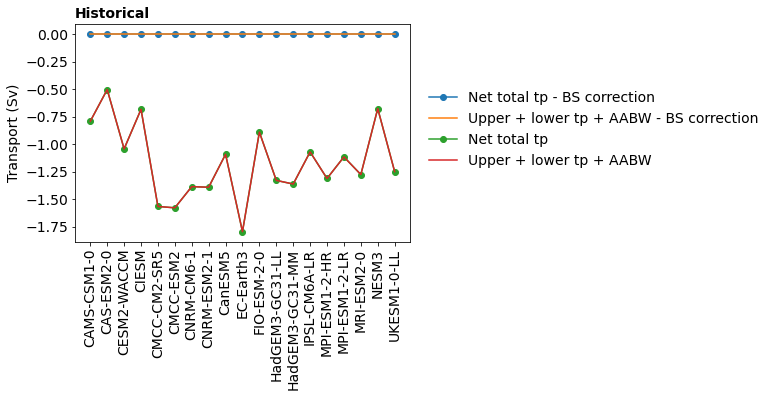

In [42]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'historical'

#RAPID
gsmean    = np.nanmean(gs)
AABWmean  = np.nanmean(AABW)
lNADWmean = np.nanmean(lNADW)
uNADWmean = np.nanmean(uNADW)
iwmean    = np.nanmean(iw)
trmean    = np.nanmean(tr)
ekmmean   = np.nanmean(ekm)

up   = ekmmean + trmean + iwmean + gsmean
down = uNADWmean + lNADWmean

print('RAPID')
print('upper tp = ' + str(up))
print('lower tp = ' + str(down))
print('AABW =' + str(AABWmean))

#Model average
up      = np.zeros(len(totmod))
down    = np.zeros(len(totmod))
maxsfbt = np.zeros(len(totmod))
maxsftb = np.zeros(len(totmod))
tpsum   = np.zeros(len(totmod))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    tp10    = ncid.variables['tp10_BS'][:,:,:]
    lev     = ncid.variables['lev'][:]
    ncid.close()
    
    tpmean   = np.nanmean(tp10,axis=0)
    tprow    = np.nansum(tpmean,axis=-1)
    mocbt    = -1*np.cumsum(tprow[::-1])[::-1]
    moctb    = np.cumsum(tprow)
    ilev     = np.nanargmin(np.abs(lev-200))
    maxsfbt1 = max(mocbt[ilev::])                #Make sure max is not at the surface
    maxsftb1 = max(moctb[ilev::])
    
    maxsfbt[i] = maxsfbt1
    maxsftb[i] = maxsftb1
    up[i]      = ektmean[i] + trtmean[i] + iwtmean[i] + fstmean[i]
    down[i]    = uNADWtmean[i] + lNADWtmean[i] 

    tpsum[i] = np.nansum(np.nansum(tpmean,axis=0),axis=0)
    
plt.figure(2)
plt.xticks(rotation=90)
plt.plot(totmod,tpsum,marker='.',markersize=12,label='Net total tp - BS correction')
plt.plot(totmod,(up+down+AABWtmean),label='Upper + lower tp + AABW - BS correction')
plt.ylabel('Transport (Sv)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 14},frameon=False)

# NO CORRECTION
t10 = 129
fs10totnc    = np.zeros((t10,len(totmod)))
AABW10totnc  = np.zeros((t10,len(totmod)))
lNADW10totnc = np.zeros((t10,len(totmod)))
uNADW10totnc = np.zeros((t10,len(totmod)))
iw10totnc    = np.zeros((t10,len(totmod)))
tr10totnc    = np.zeros((t10,len(totmod)))
ek10totnc    = np.zeros((t10,len(totmod)))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/components_tp/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    fs10nc    = ncid.variables['fs10'][:]        
    AABW10nc  = ncid.variables['AABW10'][:]      
    lNADW10nc = ncid.variables['lNADW10'][:]     
    uNADW10nc = ncid.variables['uNADW10'][:]     
    iw10nc    = ncid.variables['iw10'][:]      
    tr10nc    = ncid.variables['tr10'][:]    
    ek10nc    = ncid.variables['ek10'][:]      
    ncid.close()
    
    fs10totnc[:,i]    = fs10nc
    AABW10totnc[:,i]  = AABW10nc
    lNADW10totnc[:,i] = lNADW10nc
    uNADW10totnc[:,i] = uNADW10nc
    iw10totnc[:,i]    = iw10nc
    tr10totnc[:,i]    = tr10nc
    ek10totnc[:,i]    = ek10nc

#Calculate mean transport of all models
fsmeannc = np.nanmean(fs10totnc,axis=1)
AABWmeannc = np.nanmean(AABW10totnc,axis=1)
lNADWmeannc = np.nanmean(lNADW10totnc,axis=1)
uNADWmeannc = np.nanmean(uNADW10totnc,axis=1)
iwmeannc = np.nanmean(iw10totnc,axis=1)
trmeannc = np.nanmean(tr10totnc,axis=1)
ekmeannc = np.nanmean(ek10totnc,axis=1)

#Calculate time mean of all models
fstmeannc = np.nanmean(fs10totnc,axis=0)
AABWtmeannc = np.nanmean(AABW10totnc,axis=0)
lNADWtmeannc = np.nanmean(lNADW10totnc,axis=0)
uNADWtmeannc = np.nanmean(uNADW10totnc,axis=0)
iwtmeannc = np.nanmean(iw10totnc,axis=0)
trtmeannc = np.nanmean(tr10totnc,axis=0)
ektmeannc = np.nanmean(ek10totnc,axis=0)

#Model average - no correction
up      = np.zeros(len(totmod))
down    = np.zeros(len(totmod))
maxsfbt = np.zeros(len(totmod))
maxsftb = np.zeros(len(totmod))
tpsum   = np.zeros(len(totmod))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    tp10    = ncid.variables['tp10'][:,:,:]
    lev     = ncid.variables['lev'][:]
    ncid.close()
    
    tpmean   = np.nanmean(tp10,axis=0)
    tprow    = np.nansum(tpmean,axis=-1)
    mocbt    = -1*np.cumsum(tprow[::-1])[::-1]
    moctb    = np.cumsum(tprow)
    ilev     = np.nanargmin(np.abs(lev-200))
    maxsfbt1 = max(mocbt[ilev::])                #Make sure max is not at the surface
    maxsftb1 = max(moctb[ilev::])
    
    maxsfbt[i] = maxsfbt1
    maxsftb[i] = maxsftb1
    up[i]      = ektmeannc[i] + trtmeannc[i] + iwtmeannc[i] + fstmeannc[i]
    down[i]    = uNADWtmeannc[i] + lNADWtmeannc[i] 

    tpsum[i] = np.nansum(np.nansum(tpmean,axis=0),axis=0)
    
plt.figure(2)
plt.title('Historical',fontsize=14,fontweight='bold',loc='left')
plt.xticks(rotation=90)
plt.plot(totmod,tpsum,marker='.',markersize=12,label='Net total tp')
plt.plot(totmod,(up+down+AABWtmeannc),label='Upper + lower tp + AABW')
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 14},frameon=False)

#### SSP585

##### Timeseries

fs      -10.994826
ek        0.040892
tr        4.326061
iw        0.083962
uNADW     5.026708
lNADW     1.338570
AABW      0.178633
NADW      6.365278
MOC      -6.543911
dtype: float64
0 - 31.0273298550328
1 - 2.2176223140648244
2 - 3.176708580468583
3 - 9.872728916924206
4 - 0.7239414544915045
5 - 31.566783393919298
6 - 3.3747716906520684
7 - 9.240394093593984


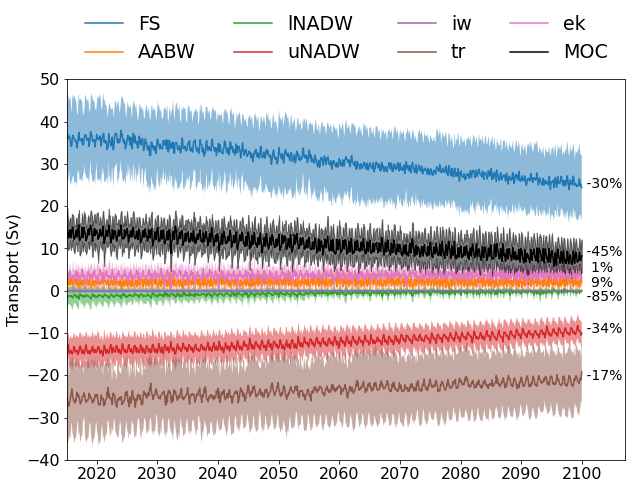

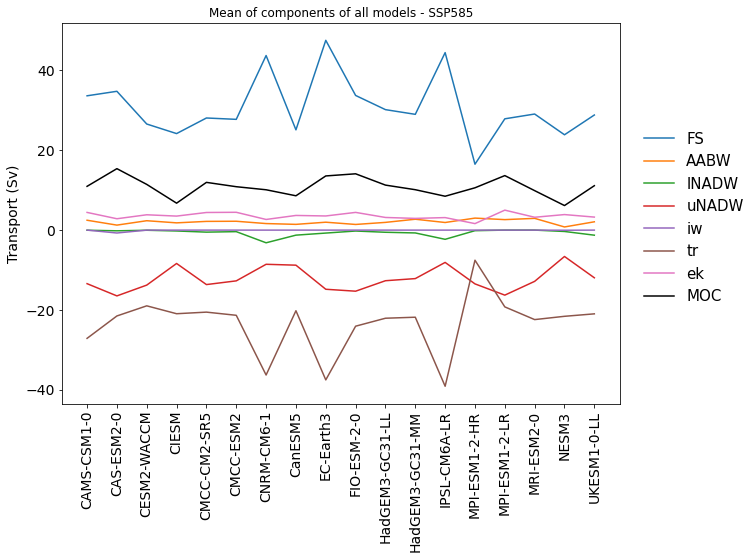

In [52]:
#CNRM-ESM2-1 (r2i1p1f2) has no ssp585
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'ssp585'

t = 85*12       #2015 - 2100
fs85tot    = np.zeros((t,len(totmod)))
AABW85tot  = np.zeros((t,len(totmod)))
lNADW85tot = np.zeros((t,len(totmod)))
uNADW85tot = np.zeros((t,len(totmod)))
iw85tot    = np.zeros((t,len(totmod)))
tr85tot    = np.zeros((t,len(totmod)))
ek85tot    = np.zeros((t,len(totmod)))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/components_tpBS/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    fs85    = ncid.variables['fs85'][:]        
    AABW85  = ncid.variables['AABW85'][:]      
    lNADW85 = ncid.variables['lNADW85'][:]     
    uNADW85 = ncid.variables['uNADW85'][:]     
    iw85    = ncid.variables['iw85'][:]      
    tr85    = ncid.variables['tr85'][:]    
    ek85    = ncid.variables['ek85'][:]      
    ncid.close()
    
    fs85tot[:,i]    = fs85
    AABW85tot[:,i]  = AABW85
    lNADW85tot[:,i] = lNADW85
    uNADW85tot[:,i] = uNADW85
    iw85tot[:,i]    = iw85
    tr85tot[:,i]    = tr85
    ek85tot[:,i]    = ek85
    
#Calculate time series ensemble mean transport
fsmean = np.nanmean(fs85tot,axis=1)
AABWmean = np.nanmean(AABW85tot,axis=1)
lNADWmean = np.nanmean(lNADW85tot,axis=1)
uNADWmean = np.nanmean(uNADW85tot,axis=1)
iwmean = np.nanmean(iw85tot,axis=1)
trmean = np.nanmean(tr85tot,axis=1)
ekmean = np.nanmean(ek85tot,axis=1)
mocmean = fsmean + iwmean + trmean + ekmean

#Calculate time mean of all models
fstmean = np.nanmean(fs85tot,axis=0)
AABWtmean = np.nanmean(AABW85tot,axis=0)
lNADWtmean = np.nanmean(lNADW85tot,axis=0)
uNADWtmean = np.nanmean(uNADW85tot,axis=0)
iwtmean = np.nanmean(iw85tot,axis=0)
trtmean = np.nanmean(tr85tot,axis=0)
ektmean = np.nanmean(ek85tot,axis=0)
moctmean = fstmean + iwtmean + trtmean + ektmean

#Change time to date
outfile = ('/home/users/jordi/section26data/' + totmod[0] + '_' + EXP + '_' + ENS[0] + '.nc')   #First model data: 2015-01-16 - 2099-12-16
ncid    = Dataset(outfile,'r')
time    = ncid.variables['time'][:]
ncid.close()

tdate = pd.to_datetime(time,unit='D',origin=pd.Timestamp('2015-01-16'))

#Compute standard deviation of ensemble mean
data = [fs85tot,ek85tot,tr85tot,iw85tot,uNADW85tot,lNADW85tot,AABW85tot,(fs85tot+ek85tot+tr85tot+iw85tot)]
comp_col = ['fs','ek','tr','iw','uNADW','lNADW','AABW','MOC']

std  = np.zeros((len(data),len(tdate)))
for i in range(len(data)):
    std[i] = np.std(data[i],axis=1)
    
std_df = pd.DataFrame(data=np.transpose(std),columns=comp_col)

#Compute decrease over ssp585 period (%)
histmean_dldf = pd.read_pickle('histmean_dldf.pkl')
mean99_df     = pd.read_pickle('mean99_mod.pkl')

histmean   = histmean_dldf.mean(axis=0)
ssp585mean = mean99_df.mean(axis=0)
dcl    = np.round(100*(ssp585mean-histmean)/histmean)
dclabs = ssp585mean - histmean

print(dclabs)

plt.figure(1,figsize=(10,7))
#plt.title('Model average transport for all components')
plt.plot(tdate,fsmean,label='FS')
plt.fill_between(tdate,fsmean-std_df['fs'],fsmean+std_df['fs'],alpha=0.5)
plt.text(tdate[-1],fsmean[-1],' ' + str(int(dcl['fs'])) + '%',fontsize=14)
plt.plot(tdate,AABWmean,label='AABW')
plt.fill_between(tdate,AABWmean-std_df['AABW'],AABWmean+std_df['AABW'],alpha=0.5)
plt.text(tdate[-1],1,'  ' + str(int(dcl['AABW'])) + '%',fontsize=14)
plt.plot(tdate,lNADWmean,label='lNADW')
plt.fill_between(tdate,lNADWmean-std_df['lNADW'],lNADWmean+std_df['lNADW'],alpha=0.5)
plt.text(tdate[-1],-2.5,' ' + str(int(dcl['lNADW'])) + '%',fontsize=14)
plt.plot(tdate,uNADWmean,label='uNADW')
plt.fill_between(tdate,uNADWmean-std_df['uNADW'],uNADWmean+std_df['uNADW'],alpha=0.5)
plt.text(tdate[-1],uNADWmean[-1],' ' + str(int(dcl['uNADW'])) + '%',fontsize=14)
plt.plot(tdate,iwmean,label='iw')
plt.fill_between(tdate,iwmean-std_df['iw'],iwmean+std_df['iw'],alpha=0.5)
#plt.text(tdate[-1],iwmean[-1],' ' + str(int(dcl['iw'])) + '%',fontsize=14)
plt.plot(tdate,trmean,label='tr')
plt.fill_between(tdate,trmean-std_df['tr'],trmean+std_df['tr'],alpha=0.5)
plt.text(tdate[-1],-21,' ' + str(int(dcl['tr'])) + '%',fontsize=14)
plt.plot(tdate,ekmean,label='ek')
plt.fill_between(tdate,ekmean-std_df['ek'],ekmean+std_df['ek'],alpha=0.5)
plt.text(tdate[-1],4.5,'  ' + str(int(dcl['ek'])) + '%',fontsize=14)
plt.plot(tdate,mocmean,label='MOC',color='k')
plt.fill_between(tdate,mocmean-std_df['MOC'],mocmean+std_df['MOC'],alpha=0.5,color='k')
plt.text(tdate[-1],mocmean[-1],' ' + str(int(dcl['MOC'])) + '%',fontsize=14)
plt.gca().set_ylim([-40,50])
plt.ylabel('Transport (Sv)',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=tdate[0],right=pd.Timestamp('2107-01-16'))
#plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 19},frameon=False)
plt.legend(loc='lower right',bbox_to_anchor=(1, 1),ncol = 4,prop={'size': 19},frameon=False)

plt.figure(2,figsize=(10,7))
plt.title('Mean of components of all models - SSP585')
plt.xticks(rotation=90)
plt.plot(totmod,fstmean,label='FS')
plt.plot(totmod,AABWtmean,label='AABW')
plt.plot(totmod,lNADWtmean,label='lNADW')
plt.plot(totmod,uNADWtmean,label='uNADW')
plt.plot(totmod,iwtmean,label='iw')
plt.plot(totmod,trtmean,label='tr')
plt.plot(totmod,ektmean,label='ek')
plt.plot(totmod,moctmean,label='MOC',color='k')
plt.ylabel('Transport (Sv)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 15},frameon=False)

ctmean = [fstmean,AABWtmean,lNADWtmean,uNADWtmean,iwtmean,trtmean,ektmean,moctmean]
for i in range(len(ctmean)):
    print(str(i) + ' - ' + str(max(ctmean[i]) - min(ctmean[i])))

##### Write time series to file for lagged regression

In [76]:
#Compute annual timeseries
NADWmean = uNADWmean + lNADWmean

fs_annual = np.zeros(85)
tr_annual = np.zeros(85)
nadw_annual = np.zeros(85)
moc_annual = np.zeros(85)
for i in range(85):
    fs_annual[i] = np.mean(fsmean[(i*12):((i+1)*12)])
    tr_annual[i] = np.mean(trmean[(i*12):((i+1)*12)])
    nadw_annual[i] = np.mean(NADWmean[(i*12):((i+1)*12)])
    moc_annual[i] = np.mean(mocmean[(i*12):((i+1)*12)])

#Write to file
outfile = ('/home/users/jordi/ssp585_ts.nc')
ncid = Dataset(outfile,'w')
ncid.createDimension('time', len(fs_annual)) 
ncid.createVariable('FS',    'f8', ('time',))
ncid.createVariable('tr',    'f8', ('time',))
ncid.createVariable('NADW',    'f8', ('time',))
ncid.createVariable('MOC',    'f8', ('time',))

ncid.variables['FS'][:]      = fs_annual
ncid.variables['tr'][:]      = tr_annual
ncid.variables['NADW'][:]    = nadw_annual
ncid.variables['MOC'][:]     = moc_annual

ncid.close()

##### Check sum of components

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: Mean of empty slice


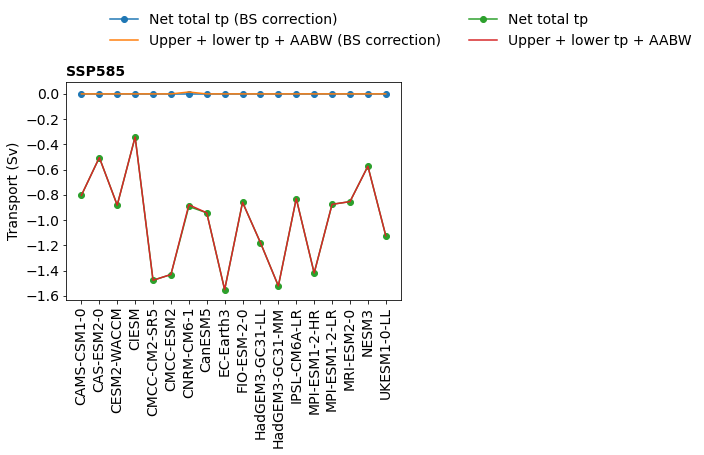

In [ ]:
#Model average
up      = np.zeros(len(totmod))
down    = np.zeros(len(totmod))
maxsfbt = np.zeros(len(totmod))
maxsftb = np.zeros(len(totmod))
tpsum   = np.zeros(len(totmod))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    tp85    = ncid.variables['tp85_BS'][:,:,:]
    lev     = ncid.variables['lev'][:]
    ncid.close()
    
    tpmean   = np.nanmean(tp85,axis=0)
    tprow    = np.nansum(tpmean,axis=-1)
    mocbt    = -1*np.cumsum(tprow[::-1])[::-1]
    moctb    = np.cumsum(tprow)
    ilevmin     = np.nanargmin(np.abs(lev-200))
    ilevmax = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
        
    if totmod[i] == 'NESM3':                     #NESM3 has a peak in overturning at surface up till depths of ~700m
        ilevmin = np.nanargmin(np.abs(lev-800))
            
    maxsfbt1 = max(mocbt[ilevmin:ilevmax])                #Make sure max is not at the surface
    maxsftb1 = max(moctb[ilevmin:ilevmax])
    
    maxsfbt[i] = maxsfbt1
    maxsftb[i] = maxsftb1
    up[i]      = ektmean[i] + trtmean[i] + iwtmean[i] + fstmean[i]
    down[i]    = uNADWtmean[i] + lNADWtmean[i] 

    tpsum[i] = np.nansum(np.nansum(tpmean,axis=0),axis=0)

plt.figure(2)
plt.xticks(rotation=90)
plt.plot(totmod,tpsum,marker='.',markersize=12,label='Net total tp (BS correction)')
plt.plot(totmod,(up+down+AABWtmean),label='Upper + lower tp + AABW (BS correction)')
plt.ylabel('Transport (Sv)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 14},frameon=False)

# NO CORRECTION
#CNRM-ESM2-1 (r2i1p1f2) has no ssp585
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'ssp585'

t = 85*12       #2015 - 2100
fs85totnc    = np.zeros((t,len(totmod)))
AABW85totnc  = np.zeros((t,len(totmod)))
lNADW85totnc = np.zeros((t,len(totmod)))
uNADW85totnc = np.zeros((t,len(totmod)))
iw85totnc    = np.zeros((t,len(totmod)))
tr85totnc    = np.zeros((t,len(totmod)))
ek85totnc    = np.zeros((t,len(totmod)))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/components_tp/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    fs85nc    = ncid.variables['fs85'][:]        
    AABW85nc  = ncid.variables['AABW85'][:]      
    lNADW85nc = ncid.variables['lNADW85'][:]     
    uNADW85nc = ncid.variables['uNADW85'][:]     
    iw85nc    = ncid.variables['iw85'][:]      
    tr85nc    = ncid.variables['tr85'][:]    
    ek85nc    = ncid.variables['ek85'][:]      
    ncid.close()
    
    fs85totnc[:,i]    = fs85nc
    AABW85totnc[:,i]  = AABW85nc
    lNADW85totnc[:,i] = lNADW85nc
    uNADW85totnc[:,i] = uNADW85nc
    iw85totnc[:,i]    = iw85nc
    tr85totnc[:,i]    = tr85nc
    ek85totnc[:,i]    = ek85nc

#Calculate mean transport of all models
fsmeannc = np.nanmean(fs85totnc,axis=1)
AABWmeannc = np.nanmean(AABW85totnc,axis=1)
lNADWmeannc = np.nanmean(lNADW85totnc,axis=1)
uNADWmeannc = np.nanmean(uNADW85totnc,axis=1)
iwmeannc = np.nanmean(iw85totnc,axis=1)
trmeannc = np.nanmean(tr85totnc,axis=1)
ekmeannc = np.nanmean(ek85totnc,axis=1)

#Calculate time mean of all models
fstmeannc = np.nanmean(fs85totnc,axis=0)
AABWtmeannc = np.nanmean(AABW85totnc,axis=0)
lNADWtmeannc = np.nanmean(lNADW85totnc,axis=0)
uNADWtmeannc = np.nanmean(uNADW85totnc,axis=0)
iwtmeannc = np.nanmean(iw85totnc,axis=0)
trtmeannc = np.nanmean(tr85totnc,axis=0)
ektmeannc = np.nanmean(ek85totnc,axis=0)

#Model average
up      = np.zeros(len(totmod))
down    = np.zeros(len(totmod))
maxsfbt = np.zeros(len(totmod))
maxsftb = np.zeros(len(totmod))
tpsum   = np.zeros(len(totmod))
for i in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')
    ncid    = Dataset(outfile,'r')
    tp85    = ncid.variables['tp85'][:,:,:]
    lev     = ncid.variables['lev'][:]
    ncid.close()
    
    tpmean   = np.nanmean(tp85,axis=0)
    tprow    = np.nansum(tpmean,axis=-1)
    mocbt    = -1*np.cumsum(tprow[::-1])[::-1]
    moctb    = np.cumsum(tprow)
    ilevmin     = np.nanargmin(np.abs(lev-200))
    ilevmax = np.nanargmin(np.abs(lev-2000))         #Find index where lev = 2000, so outlier where imax = -1 is solved
        
    if totmod[i] == 'NESM3':                     #NESM3 has a peak in overturning at surface up till depths of ~700m
        ilevmin = np.nanargmin(np.abs(lev-800))
            
    maxsfbt1 = max(mocbt[ilevmin:ilevmax])                #Make sure max is not at the surface
    maxsftb1 = max(moctb[ilevmin:ilevmax])
    
    maxsfbt[i] = maxsfbt1
    maxsftb[i] = maxsftb1
    up[i]      = ektmeannc[i] + trtmeannc[i] + iwtmeannc[i] + fstmeannc[i]
    down[i]    = uNADWtmeannc[i] + lNADWtmeannc[i] 

    tpsum[i] = np.nansum(np.nansum(tpmean,axis=0),axis=0)
    
plt.figure(2)
plt.title('SSP585',fontsize=14,fontweight='bold',loc='left')
plt.xticks(rotation=90)
plt.plot(totmod,tpsum,marker='.',markersize=12,label='Net total tp')
plt.plot(totmod,(up+down+AABWtmeannc),label='Upper + lower tp + AABW')
plt.legend(loc='lower center',bbox_to_anchor=(1, 1.1),ncol = 2,prop={'size': 14},frameon=False)

#### Compare historical and SSP585 period

##### Compare historical mean with 2090-2099 mean

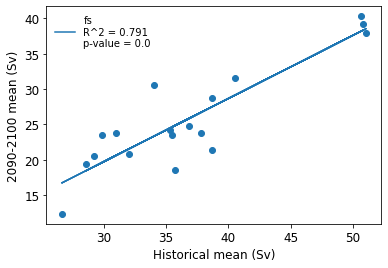

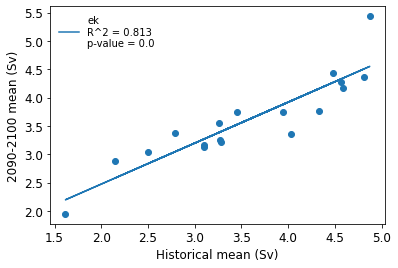

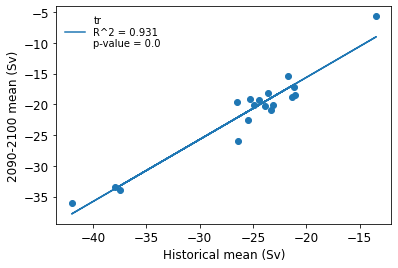

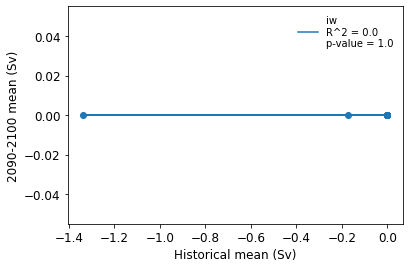

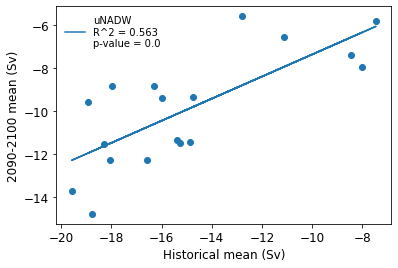

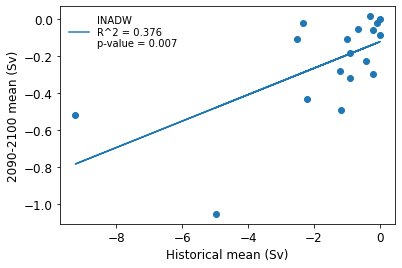

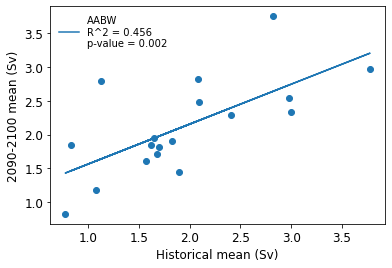

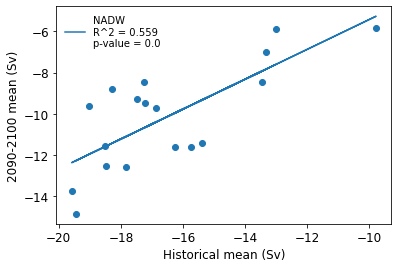

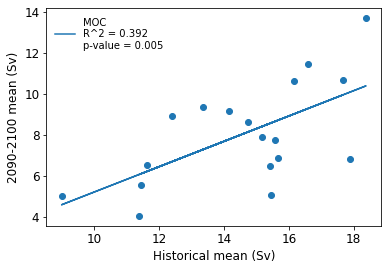

In [11]:
#Delete CNRM-ESM2-1
fstmean_dl = np.delete(np.nanmean(fs10tot,axis=0),7)
AABWtmean_dl = np.delete(np.nanmean(AABW10tot,axis=0),7)
lNADWtmean_dl = np.delete(np.nanmean(lNADW10tot,axis=0),7)
uNADWtmean_dl = np.delete(np.nanmean(uNADW10tot,axis=0),7)
iwtmean_dl = np.delete(np.nanmean(iw10tot,axis=0),7)
trtmean_dl = np.delete(np.nanmean(tr10tot,axis=0),7)
ektmean_dl = np.delete(np.nanmean(ek10tot,axis=0),7)
NADWtmean_dl = (lNADWtmean_dl + uNADWtmean_dl)
MOCtmean_dl   = (fstmean_dl+iwtmean_dl+trtmean_dl+ektmean_dl)

comp = ['fs','ek','tr','iw','uNADW','lNADW','AABW','NADW','MOC']
mean_dldf = pd.DataFrame(data=np.transpose([fstmean_dl,ektmean_dl,trtmean_dl,iwtmean_dl,uNADWtmean_dl,lNADWtmean_dl,AABWtmean_dl,NADWtmean_dl,MOCtmean_dl]),columns=comp)
#mean_dldf.to_pickle('/home/users/jordi/histmean_dldf.pkl')

fstmean99 = np.nanmean(fs85tot[-120::],axis=0)
AABWtmean99 = np.nanmean(AABW85tot[-120::],axis=0)
lNADWtmean99 = np.nanmean(lNADW85tot[-120::],axis=0)
uNADWtmean99 = np.nanmean(uNADW85tot[-120::],axis=0)
iwtmean99 = np.nanmean(iw85tot[-120::],axis=0)
trtmean99 = np.nanmean(tr85tot[-120::],axis=0)
ektmean99 = np.nanmean(ek85tot[-120::],axis=0)
NADWtmean99 = (lNADWtmean99 + uNADWtmean99)
MOCtmean99   = (fstmean99+iwtmean99+trtmean99+ektmean99)

mean99_df = pd.DataFrame(data=np.transpose([fstmean99,ektmean99,trtmean99,iwtmean99,uNADWtmean99,lNADWtmean99,AABWtmean99,NADWtmean99,MOCtmean99]),columns=comp)
#mean99_df.to_pickle('/home/users/jordi/mean99_mod.pkl')

for i in range (len(comp)):
    plt.figure(i)
    plt.scatter(mean_dldf[comp[i]],mean99_df[comp[i]])
    slope, intercept, rvalue, pvalue, stderr = st.linregress(mean_dldf[comp[i]],mean99_df[comp[i]])
    plt.plot(mean_dldf[comp[i]],slope*mean_dldf[comp[i]]+intercept,label= str(comp[i]) + '\nR^2 = ' + str(round(rvalue**2,3)) + '\np-value = ' + str(round(pvalue,3)))
    plt.xlabel('Historical mean (Sv)',fontsize=12)
    plt.ylabel('2090-2100 mean (Sv)',fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(frameon=False)

##### Plot SSP585 change and relate to historical mean

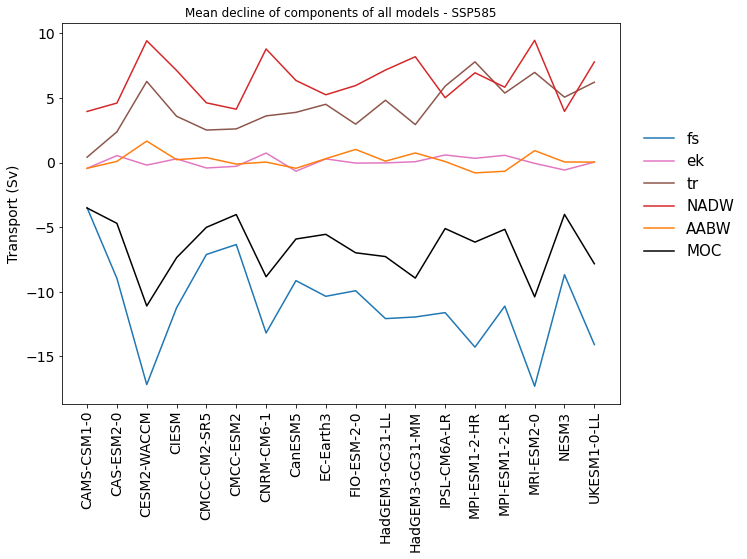

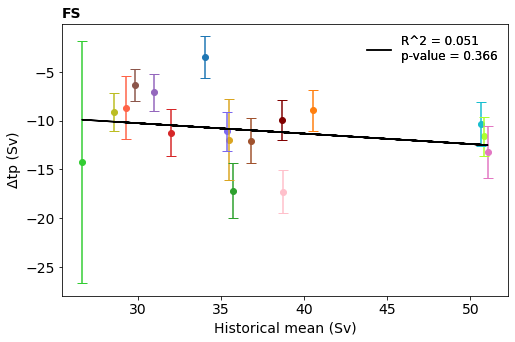

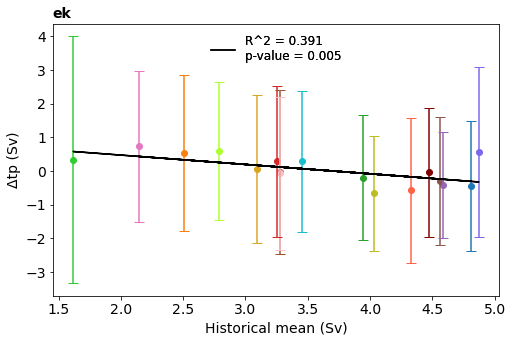

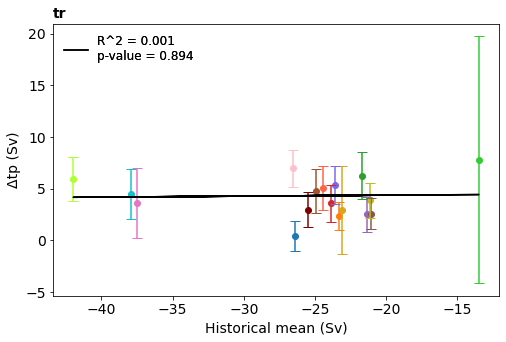

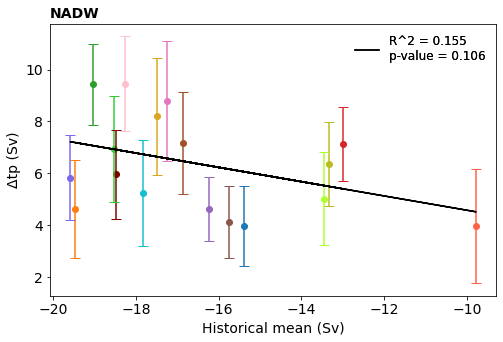

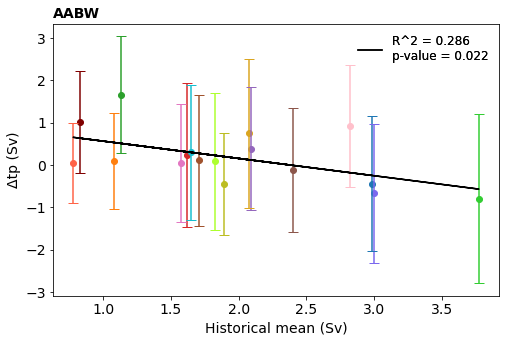

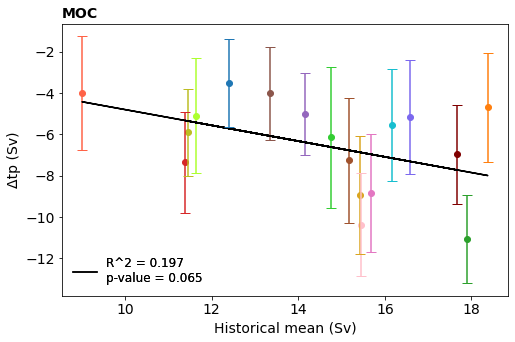

In [17]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
#'CAS-ESM2-0'

comp = ['fs','ek','tr','iw','uNADW','lNADW','AABW','NADW','MOC']
mean_dldf = pd.DataFrame(data=np.transpose([fstmean_dl,ektmean_dl,trtmean_dl,iwtmean_dl,uNADWtmean_dl,lNADWtmean_dl,AABWtmean_dl,NADWtmean_dl,MOCtmean_dl]),columns=comp)

fsdif   = np.abs(fstmean99) - np.abs(fstmean_dl)
AABWdif = np.abs(AABWtmean99) - np.abs(AABWtmean_dl)
NADWdif = np.abs((lNADWtmean99 + uNADWtmean99)) - np.abs((lNADWtmean_dl + uNADWtmean_dl))
trdif   = np.abs(trtmean99) - np.abs(trtmean_dl)
ekdif   = np.abs(ektmean99) - np.abs(ektmean_dl)
MOCdif  = np.abs(MOCtmean99) - np.abs(MOCtmean_dl)

fsdif   = fstmean99 - fstmean_dl
AABWdif = AABWtmean99 - AABWtmean_dl
NADWdif = (lNADWtmean99 + uNADWtmean99) - (lNADWtmean_dl + uNADWtmean_dl)
trdif   = trtmean99 - trtmean_dl
ekdif   = ektmean99 - ektmean_dl
MOCdif  = MOCtmean99 - MOCtmean_dl

comp = ['fs','ek','tr','NADW','AABW','MOC']
diff_df = pd.DataFrame(data=np.transpose([fsdif,ekdif,trdif,NADWdif,AABWdif,MOCdif]),columns=comp,index=totmod)
#diff_df.to_pickle('/home/users/jordi/diff_mod.pkl')

std_dldf = std_df.drop([7],axis=0)
std_dldf = std_dldf.set_index(np.linspace(0,17,18))

clr = ['tab:blue','tab:pink','tab:brown','tab:red','tab:orange','k']
plt.figure(1,figsize=(10,7))
plt.title('Mean decline of components of all models - SSP585')
for i in range(len(comp)):
    plt.plot(totmod,diff_df[comp[i]],label=comp[i],color=clr[i])    
plt.xticks(rotation=90)
plt.ylabel('Transport (Sv)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 0.75),prop={'size': 15},frameon=False)

#Delete outlier to examine the impact on relationship
#mean_dldf = mean_dldf.drop([16],axis=0)
#mean_dldf = mean_dldf.reset_index(drop=True)

#diff_df = diff_df.drop(['NESM3'],axis=0)
#diff_df = diff_df.reset_index(drop=True)

comp_title = ['FS','ek','tr','NADW','AABW','MOC']
color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen']
for i in range(len(comp)):
    plt.figure(i+2,figsize=(8,5))
    #plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','tomato','lightgreen'])
    slope, intercept, rvalue, pvalue, stderr = st.linregress(mean_dldf[comp[i]],diff_df[comp[i]])
    lreg, = plt.plot(mean_dldf[comp[i]],slope*mean_dldf[comp[i]]+intercept,color='k')
    for j in range(len(totmod)-1):
        scat = plt.scatter(mean_dldf[comp[i]][j],diff_df[comp[i]][j],label=str(totmod[j]),color=color[j])
        err  = plt.errorbar(mean_dldf[comp[i]][j],diff_df[comp[i]][j],yerr=std_dldf[comp[i]][j],fmt='None',color=color[j],capsize=5)
        plt.legend(handles=[scat],loc='center left',bbox_to_anchor=(1.02, 0.5),prop={'size': 12},frameon=False)
    plt.title(comp_title[i],loc='left',fontsize=14,fontweight='bold')
    plt.xlabel('Historical mean (Sv)',fontsize=14)
    plt.ylabel('Δtp (Sv)',fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    leg1 = plt.legend([lreg],['R^2 = ' + str(round(rvalue**2,3)) + '\np-value = ' + str(round(pvalue,3))],prop={'size': 12},frameon=False)
    #plt.legend(loc='center left',bbox_to_anchor=(1.02, 0.5),prop={'size': 12},frameon=False)
    #plt.legend(loc='lower center',bbox_to_anchor=(1, 1.1),ncol = 5,prop={'size': 14},frameon=False)
    plt.gca().add_artist(leg1)

#### Check time units

In [52]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'ssp585'

for i in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')   #First model has 365 day calendar starting 01-01-1850
    ncid    = Dataset(outfile,'r')
    time    = ncid.variables['time'][:]
    units   = ncid.variables['time'].units
    print(str(totmod[i]) + ' - ' + str(time[0]) + str(np.shape(time)))
    print(str(totmod[i]) + ' - ' + str(units))
    ncid.close()

CAMS-CSM1-0 - 15.5(1020,)
CAMS-CSM1-0 - days since 2015-1-1 00:00
CAS-ESM2-0 - 735125.5416666667(1032,)
CAS-ESM2-0 - days since 0001-01-01 00:00:00
CESM2-WACCM - 735124.5416666667(3420,)
CESM2-WACCM - days since 0001-01-01 00:00:00
CIESM - 735125.5(1032,)
CIESM - days since 0001-01-01 00:00:00
CMCC-CM2-SR5 - 60240.5(1032,)
CMCC-CM2-SR5 - days since 1850-01-01
CMCC-ESM2 - 60240.5(1032,)
CMCC-ESM2 - days since 1850-01-01
CNRM-CM6-1 - 60280.5(1032,)
CNRM-CM6-1 - days since 1850-01-01 00:00:00
CanESM5 - 60240.5(3432,)
CanESM5 - days since 1850-01-01 0:0:0.0
EC-Earth3 - 60280.5(1032,)
EC-Earth3 - days since 1850-01-01 00:00:00
FIO-ESM-2-0 - 735125.5875000001(1032,)
FIO-ESM-2-0 - days since 0001-01-01
HadGEM3-GC31-LL - 59415.0(1032,)
HadGEM3-GC31-LL - days since 1850-01-01
HadGEM3-GC31-MM - 59415.0(1032,)
HadGEM3-GC31-MM - days since 1850-01-01
IPSL-CM6A-LR - 15.5(3432,)
IPSL-CM6A-LR - days since 2015-01-01 00:00:00
MIROC6 - 60280.5(1032,)
MIROC6 - days since 1850-1-1
MPI-ESM1-2-HR - 60280.5

In [53]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'historical'
totmodlist = ['CAS-ESM2-0','CESM2-WACCM','CIESM','FIO-ESM-2-0']

for i in range (len(totmod)):
    outfile = ('/home/users/jordi/section26data/' + totmod[i] + '_' + EXP + '_' + ENS[i] + '.nc')   #First model has 365 day calendar starting 01-01-1850
    ncid    = Dataset(outfile,'r')
    time    = ncid.variables['time'][-129::]
    units   = ncid.variables['time'].units
    cal     = ncid.variables['time'].calendar
    print(str(totmod[i]) + ' - ' + str(units) + ' - ' + str(cal))
    
    if totmod[i] not in totmodlist:
        time_dt = cftime.num2date(time,units,calendar=cal)
        time_pydt = cftime.num2pydate(time,units)
        print(str(totmod[i]) + ' - ' + str(time_dt[0]))
        print(str(totmod[i]) + ' - ' + str(time_pydt[0]))
    ncid.close()
    

CAMS-CSM1-0 - days since 1850-1-1 00:00 - 365_day
CAMS-CSM1-0 - 2004-04-16 00:00:00
CAMS-CSM1-0 - 2004-03-09 00:00:00
CAS-ESM2-0 - days since 0001-01-01 00:00:00 - 365_day
CESM2-WACCM - days since 0001-01-01 00:00:00 - 365_day
CIESM - days since 0001-01-01 00:00:00 - 365_day
CMCC-CM2-SR5 - days since 1850-01-01 - 365_day
CMCC-CM2-SR5 - 2004-04-16 00:00:00
CMCC-CM2-SR5 - 2004-03-09 00:00:00
CMCC-ESM2 - days since 1850-01-01 - 365_day
CMCC-ESM2 - 2004-04-16 00:00:00
CMCC-ESM2 - 2004-03-09 00:00:00
CNRM-CM6-1 - days since 1850-01-01 00:00:00 - gregorian
CNRM-CM6-1 - 2004-04-16 00:00:00
CNRM-CM6-1 - 2004-04-16 00:00:00
CNRM-ESM2-1 - days since 1850-01-01 00:00:00 - gregorian
CNRM-ESM2-1 - 2004-04-16 00:00:00
CNRM-ESM2-1 - 2004-04-16 00:00:00
CanESM5 - days since 1850-01-01 0:0:0.0 - 365_day
CanESM5 - 2004-04-16 00:00:00
CanESM5 - 2004-03-09 00:00:00
EC-Earth3 - days since 1850-01-01 00:00:00 - proleptic_gregorian
EC-Earth3 - 2004-04-16 00:00:00
EC-Earth3 - 2004-04-16 00:00:00
FIO-ESM-2-0 -